<a href="https://colab.research.google.com/github/Mamiglia/challenge/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm import tqdm
import torch.nn.functional as F

from src.common import load_data, prepare_train_data, generate_submission

In [ ]:
# Configuration
MODEL_PATH = "models/mlp_baseline.pth"
EPOCHS = 50
BATCH_SIZE = 256
LR = 0.0007
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.2):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(x + self.block(x))

class ResNetMod(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1536,hidden_dim=1280, num_blocks=2, dropout=0.45):
        super(ResNetMod, self).__init__()

        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.residual_blocks = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout) 
            for _ in range(num_blocks)
        ])

        self.output_proj = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_proj(x)

        for block in self.residual_blocks:
            x = block(x)
        
        x = self.output_proj(x)
        return x


In [83]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False


In [ ]:
import torch.nn.functional as F

def train_model(model, train_loader, val_loader, device, epochs, lr):
    """Train the MLP model"""
    criterion = nn.CosineEmbeddingLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_val_loss = float('inf')
    early_stopping = EarlyStopping(patience=7)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)

            target = torch.ones(outputs.size(0)).to(device)
            loss = criterion(outputs, y_batch, target)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                target = torch.ones(outputs.size(0)).to(device)
                loss = criterion(outputs, y_batch, target)
                
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"Saved best model (val_loss={val_loss:.6f})")

        if early_stopping(val_loss):
            print(f"Early stopping at epoch {epoch+1}")
            break

        scheduler.step()

    return model


In [ ]:
# Load data
train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)
DATASET_SIZE = len(X)

n_train = int(0.9 * len(X))
TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
print(X_train.shape)
print(y_train.shape)

(125000,)
Train data: 125000 captions, 125000 images
torch.Size([112500, 1024])
torch.Size([112500, 1536])


In [ ]:
model = ResNetMod().to(DEVICE)
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train
print("\n3. Training")
model = train_model(model, train_loader, val_loader, DEVICE, EPOCHS, LR)

# Load best model for evaluation
model.load_state_dict(torch.load(MODEL_PATH))


   Parameters: 9,851,136

3. Training...


Epoch 1/50: 100%|██████████| 440/440 [00:05<00:00, 75.77it/s]


Epoch 1: Train Loss = 0.207610, Val Loss = 0.185804
  ✓ Saved best model (val_loss=0.185804)


Epoch 2/50: 100%|██████████| 440/440 [00:05<00:00, 77.43it/s]


Epoch 2: Train Loss = 0.185119, Val Loss = 0.183827
  ✓ Saved best model (val_loss=0.183827)


Epoch 3/50: 100%|██████████| 440/440 [00:05<00:00, 79.35it/s]


Epoch 3: Train Loss = 0.183760, Val Loss = 0.183253
  ✓ Saved best model (val_loss=0.183253)


Epoch 4/50: 100%|██████████| 440/440 [00:05<00:00, 79.14it/s]


Epoch 4: Train Loss = 0.182534, Val Loss = 0.181529
  ✓ Saved best model (val_loss=0.181529)


Epoch 5/50: 100%|██████████| 440/440 [00:05<00:00, 78.88it/s]


Epoch 5: Train Loss = 0.181201, Val Loss = 0.180137
  ✓ Saved best model (val_loss=0.180137)


Epoch 6/50: 100%|██████████| 440/440 [00:05<00:00, 78.45it/s]


Epoch 6: Train Loss = 0.180023, Val Loss = 0.178978
  ✓ Saved best model (val_loss=0.178978)


Epoch 7/50: 100%|██████████| 440/440 [00:06<00:00, 69.64it/s]


Epoch 7: Train Loss = 0.179122, Val Loss = 0.178354
  ✓ Saved best model (val_loss=0.178354)


Epoch 8/50: 100%|██████████| 440/440 [00:06<00:00, 69.58it/s]


Epoch 8: Train Loss = 0.178494, Val Loss = 0.177492
  ✓ Saved best model (val_loss=0.177492)


Epoch 9/50: 100%|██████████| 440/440 [00:05<00:00, 79.09it/s]


Epoch 9: Train Loss = 0.177966, Val Loss = 0.177396
  ✓ Saved best model (val_loss=0.177396)


Epoch 10/50: 100%|██████████| 440/440 [00:05<00:00, 79.27it/s]


Epoch 10: Train Loss = 0.177537, Val Loss = 0.177172
  ✓ Saved best model (val_loss=0.177172)


Epoch 11/50: 100%|██████████| 440/440 [00:05<00:00, 78.24it/s]


Epoch 11: Train Loss = 0.177212, Val Loss = 0.176789
  ✓ Saved best model (val_loss=0.176789)


Epoch 12/50: 100%|██████████| 440/440 [00:05<00:00, 79.29it/s]


Epoch 12: Train Loss = 0.176822, Val Loss = 0.176676
  ✓ Saved best model (val_loss=0.176676)


Epoch 13/50: 100%|██████████| 440/440 [00:05<00:00, 79.39it/s]


Epoch 13: Train Loss = 0.176528, Val Loss = 0.176348
  ✓ Saved best model (val_loss=0.176348)


Epoch 14/50: 100%|██████████| 440/440 [00:05<00:00, 77.86it/s]


Epoch 14: Train Loss = 0.176228, Val Loss = 0.176167
  ✓ Saved best model (val_loss=0.176167)


Epoch 15/50: 100%|██████████| 440/440 [00:05<00:00, 79.39it/s]


Epoch 15: Train Loss = 0.175859, Val Loss = 0.175688
  ✓ Saved best model (val_loss=0.175688)


Epoch 16/50: 100%|██████████| 440/440 [00:05<00:00, 76.97it/s]


Epoch 16: Train Loss = 0.175458, Val Loss = 0.175304
  ✓ Saved best model (val_loss=0.175304)


Epoch 17/50: 100%|██████████| 440/440 [00:05<00:00, 79.24it/s]


Epoch 17: Train Loss = 0.175118, Val Loss = 0.175061
  ✓ Saved best model (val_loss=0.175061)


Epoch 18/50: 100%|██████████| 440/440 [00:05<00:00, 80.71it/s]


Epoch 18: Train Loss = 0.174728, Val Loss = 0.175209


Epoch 19/50: 100%|██████████| 440/440 [00:05<00:00, 80.81it/s]


Epoch 19: Train Loss = 0.174373, Val Loss = 0.174547
  ✓ Saved best model (val_loss=0.174547)


Epoch 20/50: 100%|██████████| 440/440 [00:05<00:00, 79.03it/s]


Epoch 20: Train Loss = 0.173991, Val Loss = 0.173874
  ✓ Saved best model (val_loss=0.173874)


Epoch 21/50: 100%|██████████| 440/440 [00:05<00:00, 80.74it/s]


Epoch 21: Train Loss = 0.173523, Val Loss = 0.174022


Epoch 22/50: 100%|██████████| 440/440 [00:05<00:00, 79.74it/s]


Epoch 22: Train Loss = 0.172993, Val Loss = 0.173603
  ✓ Saved best model (val_loss=0.173603)


Epoch 23/50: 100%|██████████| 440/440 [00:05<00:00, 78.43it/s]


Epoch 23: Train Loss = 0.172511, Val Loss = 0.172940
  ✓ Saved best model (val_loss=0.172940)


Epoch 24/50: 100%|██████████| 440/440 [00:05<00:00, 78.39it/s]


Epoch 24: Train Loss = 0.171906, Val Loss = 0.173143


Epoch 25/50: 100%|██████████| 440/440 [00:05<00:00, 76.39it/s]


Epoch 25: Train Loss = 0.171362, Val Loss = 0.172641
  ✓ Saved best model (val_loss=0.172641)


Epoch 26/50: 100%|██████████| 440/440 [00:05<00:00, 78.18it/s]


Epoch 26: Train Loss = 0.170829, Val Loss = 0.172121
  ✓ Saved best model (val_loss=0.172121)


Epoch 27/50: 100%|██████████| 440/440 [00:05<00:00, 78.89it/s]


Epoch 27: Train Loss = 0.170124, Val Loss = 0.172020
  ✓ Saved best model (val_loss=0.172020)


Epoch 28/50: 100%|██████████| 440/440 [00:05<00:00, 78.48it/s]


Epoch 28: Train Loss = 0.169330, Val Loss = 0.171495
  ✓ Saved best model (val_loss=0.171495)


Epoch 29/50: 100%|██████████| 440/440 [00:05<00:00, 77.19it/s]


Epoch 29: Train Loss = 0.168696, Val Loss = 0.171287
  ✓ Saved best model (val_loss=0.171287)


Epoch 30/50: 100%|██████████| 440/440 [00:05<00:00, 78.74it/s]


Epoch 30: Train Loss = 0.167953, Val Loss = 0.170947
  ✓ Saved best model (val_loss=0.170947)


Epoch 31/50: 100%|██████████| 440/440 [00:05<00:00, 77.00it/s]


Epoch 31: Train Loss = 0.167058, Val Loss = 0.170610
  ✓ Saved best model (val_loss=0.170610)


Epoch 32/50: 100%|██████████| 440/440 [00:05<00:00, 78.19it/s]


Epoch 32: Train Loss = 0.166226, Val Loss = 0.170443
  ✓ Saved best model (val_loss=0.170443)


Epoch 33/50: 100%|██████████| 440/440 [00:05<00:00, 78.72it/s]


Epoch 33: Train Loss = 0.165387, Val Loss = 0.169847
  ✓ Saved best model (val_loss=0.169847)


Epoch 34/50: 100%|██████████| 440/440 [00:05<00:00, 77.76it/s]


Epoch 34: Train Loss = 0.164403, Val Loss = 0.169636
  ✓ Saved best model (val_loss=0.169636)


Epoch 35/50: 100%|██████████| 440/440 [00:05<00:00, 79.33it/s]


Epoch 35: Train Loss = 0.163337, Val Loss = 0.169484
  ✓ Saved best model (val_loss=0.169484)


Epoch 36/50: 100%|██████████| 440/440 [00:05<00:00, 80.30it/s]


Epoch 36: Train Loss = 0.162248, Val Loss = 0.169315
  ✓ Saved best model (val_loss=0.169315)


Epoch 37/50: 100%|██████████| 440/440 [00:05<00:00, 80.71it/s]


Epoch 37: Train Loss = 0.161162, Val Loss = 0.168744
  ✓ Saved best model (val_loss=0.168744)


Epoch 38/50: 100%|██████████| 440/440 [00:05<00:00, 80.34it/s]


Epoch 38: Train Loss = 0.159910, Val Loss = 0.168527
  ✓ Saved best model (val_loss=0.168527)


Epoch 39/50: 100%|██████████| 440/440 [00:05<00:00, 81.44it/s]


Epoch 39: Train Loss = 0.158753, Val Loss = 0.168206
  ✓ Saved best model (val_loss=0.168206)


Epoch 40/50: 100%|██████████| 440/440 [00:05<00:00, 77.46it/s]


Epoch 40: Train Loss = 0.157530, Val Loss = 0.168284


Epoch 41/50: 100%|██████████| 440/440 [00:06<00:00, 65.38it/s]


Epoch 41: Train Loss = 0.156369, Val Loss = 0.168125
  ✓ Saved best model (val_loss=0.168125)


Epoch 42/50: 100%|██████████| 440/440 [00:05<00:00, 73.98it/s]


Epoch 42: Train Loss = 0.155241, Val Loss = 0.168095
  ✓ Saved best model (val_loss=0.168095)


Epoch 43/50: 100%|██████████| 440/440 [00:05<00:00, 79.07it/s]


Epoch 43: Train Loss = 0.154042, Val Loss = 0.168004
  ✓ Saved best model (val_loss=0.168004)


Epoch 44/50: 100%|██████████| 440/440 [00:05<00:00, 80.06it/s]


Epoch 44: Train Loss = 0.152900, Val Loss = 0.167678
  ✓ Saved best model (val_loss=0.167678)


Epoch 45/50: 100%|██████████| 440/440 [00:05<00:00, 79.88it/s]


Epoch 45: Train Loss = 0.152012, Val Loss = 0.167703


Epoch 46/50: 100%|██████████| 440/440 [00:05<00:00, 80.80it/s]


Epoch 46: Train Loss = 0.151212, Val Loss = 0.167749


Epoch 47/50: 100%|██████████| 440/440 [00:05<00:00, 79.80it/s]


Epoch 47: Train Loss = 0.150444, Val Loss = 0.167564
  ✓ Saved best model (val_loss=0.167564)


Epoch 48/50: 100%|██████████| 440/440 [00:05<00:00, 81.07it/s]


Epoch 48: Train Loss = 0.150048, Val Loss = 0.167690


Epoch 49/50: 100%|██████████| 440/440 [00:05<00:00, 80.74it/s]


Epoch 49: Train Loss = 0.149690, Val Loss = 0.167658


Epoch 50/50: 100%|██████████| 440/440 [00:05<00:00, 81.80it/s]


Epoch 50: Train Loss = 0.149635, Val Loss = 0.167596


<All keys matched successfully>

## Evaluation

### Visualize

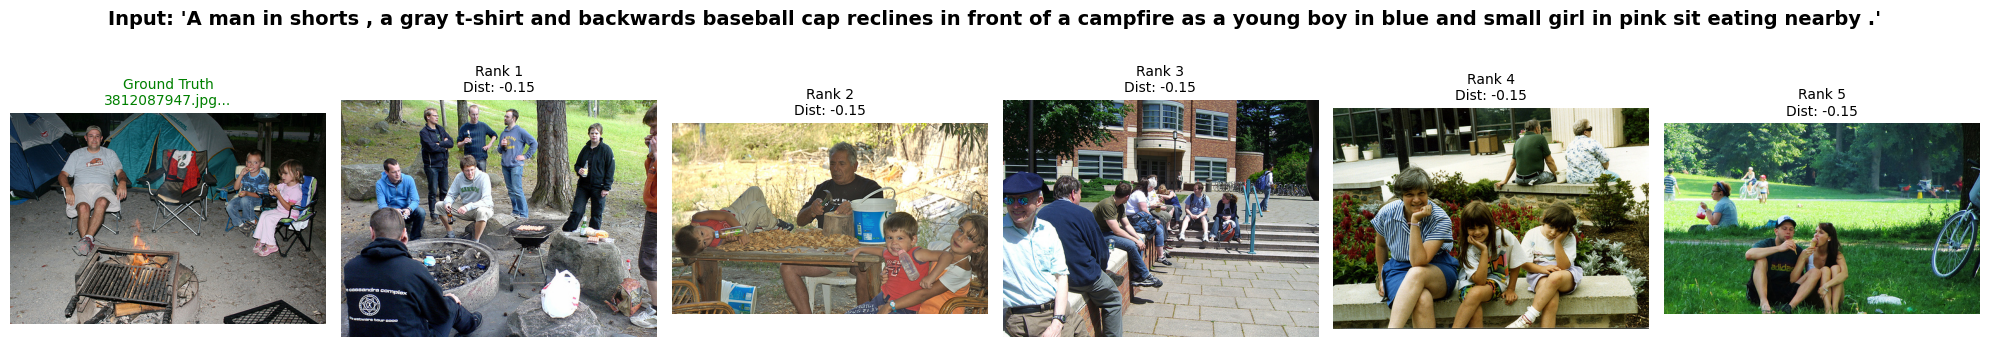

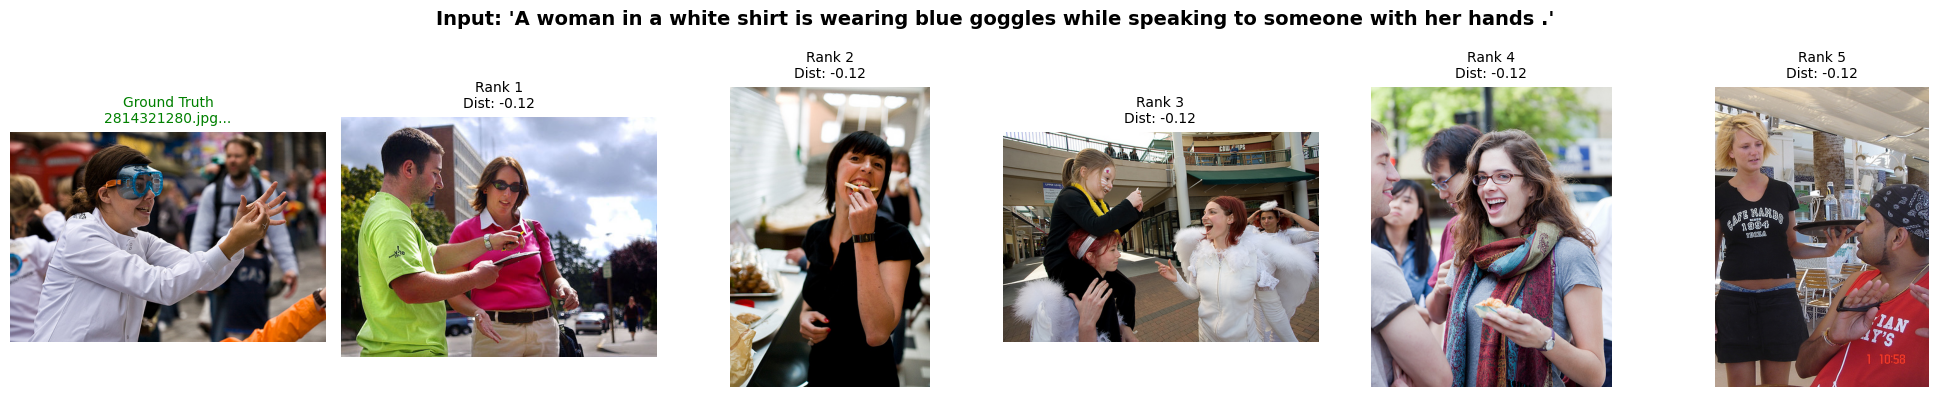

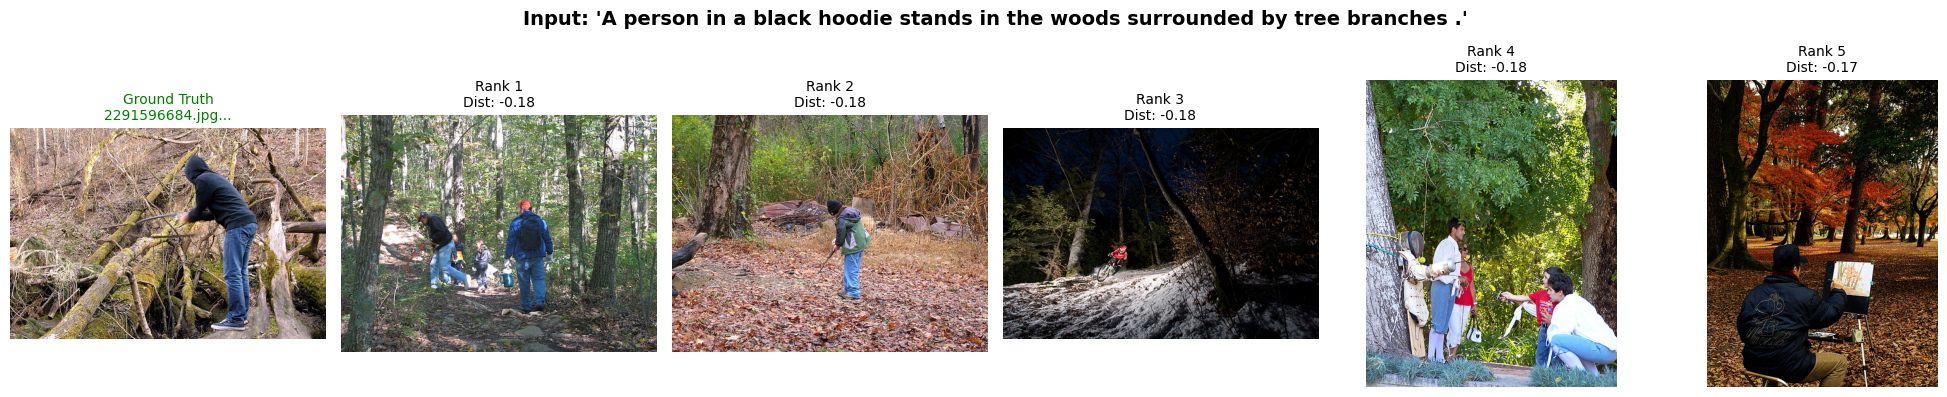

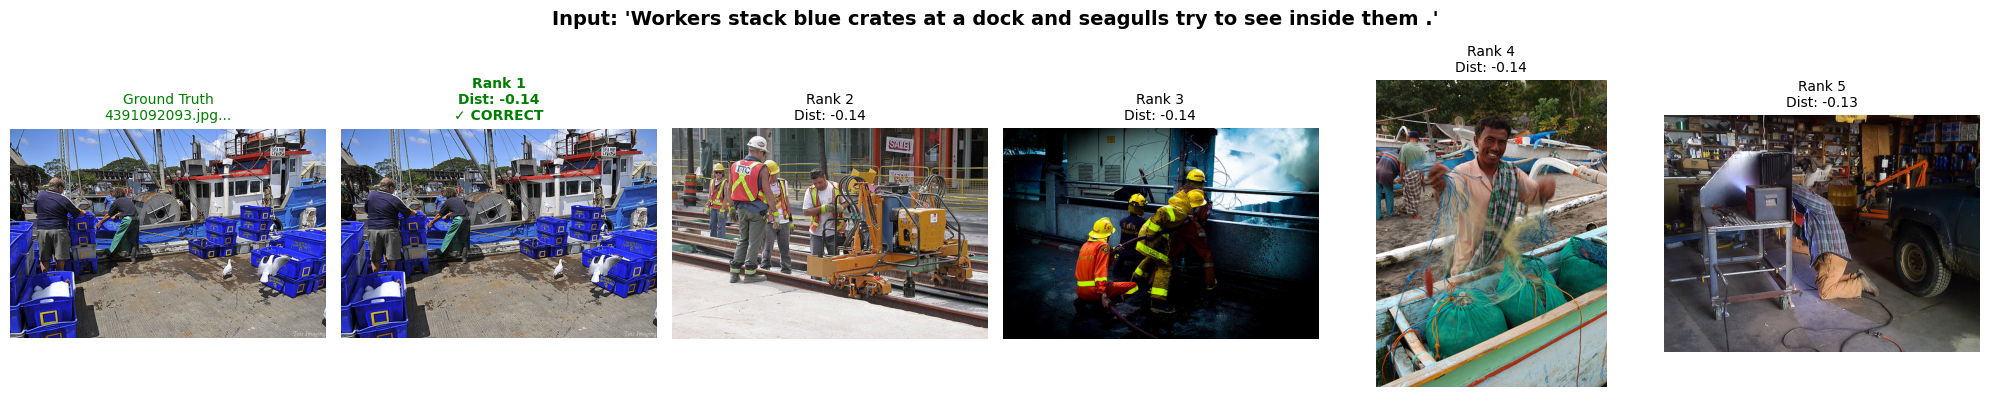

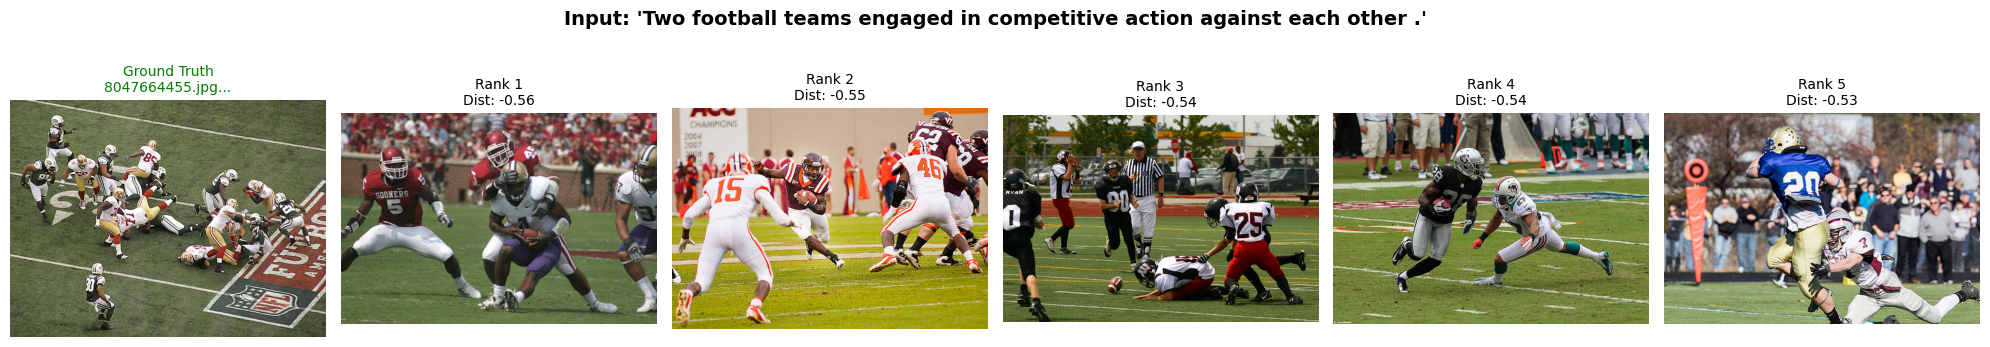

In [88]:
from src.eval import visualize_retrieval
import numpy as np
import torch

val_caption_text = train_data['captions/text'][~TRAIN_SPLIT]
val_text_embd = X_val
img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
val_img_file = train_data['images/names'][img_VAL_SPLIT]


val_img_embd_raw = train_data['images/embeddings'][img_VAL_SPLIT]
val_img_embd = torch.from_numpy(val_img_embd_raw).float()
val_img_embd = F.normalize(val_img_embd, p=2, dim=1)

val_label = np.nonzero(train_data['captions/label'][~TRAIN_SPLIT][:,img_VAL_SPLIT])[1]

# Sample and visualize
for i in range(5):
    idx = np.random.randint(0, 100)
    caption_embd = val_text_embd[idx]
    caption_text = val_caption_text[idx]
    gt_index = val_label[idx]

    with torch.no_grad():
        # Add batch dimension: [1024] → [1, 1024]
        caption_embd_batch = caption_embd.unsqueeze(0).to(DEVICE)
        
        # Model output: [1, 1536]
        pred_embds = model(caption_embd_batch).cpu()
        
        # Remove batch dimension: [1, 1536] → [1536]
        pred_embds = pred_embds.squeeze(0)

        visualize_retrieval(
            pred_embds,
            gt_index,
            val_img_file,
            caption_text, 
            val_img_embd, 
            k=5
        )

## Submission

In [89]:
test_data = load_data("data/test/test.clean.npz")
test_embds = test_data['captions/embeddings']

test_embds = torch.from_numpy(test_embds).float()

model.eval()
with torch.no_grad():
    pred_embds = model(test_embds.to(DEVICE)).cpu()

submission = generate_submission(test_data['captions/ids'], pred_embds, 'submission_resnet.csv')
print(f"Model saved to: {MODEL_PATH}")

Generating submission file...
✓ Saved submission to submission_resnet.csv
Model saved to: models/mlp_baseline.pth
